In [62]:
import numpy as np
import scipy.linalg as splin
from scipy.integrate import LSODA, solve_ivp
from consts import *
from lyapunov import *
from potential import *

In [63]:
# Initial conditions (alpha0) and Jacobi interval
alpha0 = 50/384400 # initial guess for alpha

# C = 2U(r) - (vx^2 + vy^2)
C_range = [3.1370, 3.1493]

In [64]:
#def mainFun(XL: np.ndarray, mu: float, C_range, IG):
    # XL is the lagrangian point position vector
    # mu is the relative gravitational parameter
    # C_range is the range of Jacobi constants to search for
    # IG is the initial guess for alpha (for Lyapunov orbit)
    


# Compute A at XL
A_xl = A(XL1[:2], mu)
# Diagonalize it
L, V = splin.eig(A_xl)

# Filter small values - eps = 1e-14
# V.real[np.abs(V.real) <= eps] = 0
# V.imag[np.abs(V.imag) <= eps] = 0

# Filter complex numbers with positive imaginary part
Sel =  [(i, x) for i, x in enumerate(L) if isinstance(x, complex) and x.imag > 0]
i_sel = Sel[0][0]
L_sel = Sel[0][1]

# Now take the eigenvector corresponding to that eigenvalue

V_sel = V[:, i_sel]
# Angular velocity and period
om_ly = L_sel.imag
T_ly = 2*np.pi/om_ly
# Lyapunov linearized state 
# x(t) = XL + alpha0(cos(om_ly*t)*Re(V_sel) + sin(om_ly*t)*Im(V_sel))



t_span = np.linspace(0, 2*np.pi/om_ly, 1000)
X_lyap =lin_lyapunov_orbit(XL1, om_ly, alpha0, V_sel)

    

[0]
[ 8.36913763e-01  2.06128976e-22 -1.40337326e-20 -1.15163873e-04]


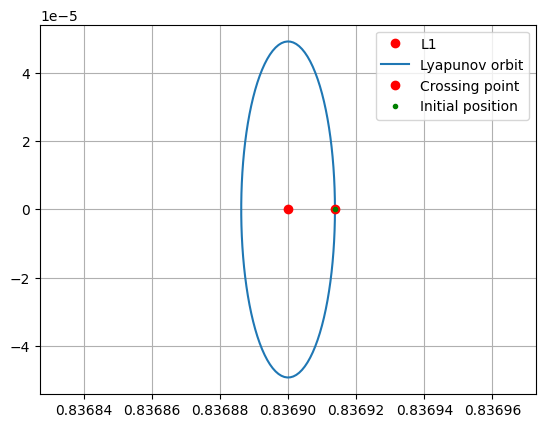

In [67]:
# Plotting cell
import matplotlib.pyplot as plt


# Plot the Lagrange point
plt.plot(XL1[0], XL1[1], 'ro', label='L1')

# Set the aspect ratio to be equal
plt.axis('equal')


# From X_lyap take the solution that crosses the x-axis
i_cross = [idx for idx in range(len(X_lyap)-1) if X_lyap[1, idx] * X_lyap[1,idx+1] < 0 and X_lyap[1, idx] > 0]
print(i_cross)
# Plot the Lyapunov orbit
plt.plot(X_lyap[0,:], X_lyap[1,:], label='Lyapunov orbit')
# Plot the crossing point
plt.plot(X_lyap[0,i_cross], X_lyap[1,i_cross], 'ro', label='Crossing point')
print(X_lyap[:, i_cross[0]])

#Plot initial position
plt.plot( X_lyap[0,0], X_lyap[1,0], 'g.', label='Initial position')
plt.grid()


plt.legend()
plt.show()




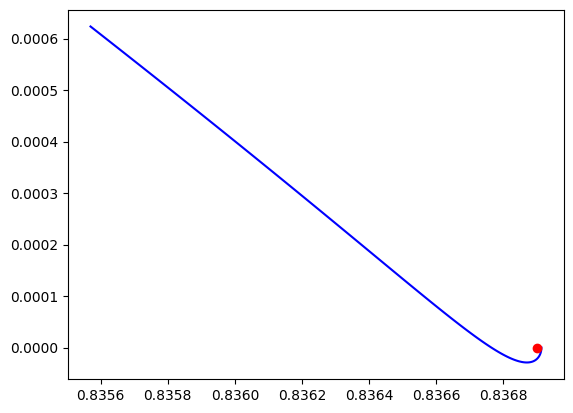

In [54]:
# Take one of the crossing points 
X0 = X_lyap[:, i_cross[0]]
for i in range(4):
    if abs(X0[i]) < eps:
        X0[i] = 0
# Concat the STM
PHI0 = np.eye(4, 4)
Y0 = np.concatenate((X0, PHI0.flatten()))
# Lets integrate the equations of motion
tau_span = np.linspace(0, 1/2, 100)

sol = solve_ivp(f, [0, 1/2], Y0, args = (T_ly, mu), t_eval=tau_span, method='LSODA', rtol=3*eps, atol=eps)

# Plot the solution
plt.plot(sol.y[0, :], sol.y[1, :], 'b')
plt.plot(XL1[0], XL1[1], 'ro')


In [55]:
# Build the initial guess for iteration
Y_guess = np.array([X0[0], X0[3], T_ly]).reshape(3,1)
Yt = [0,0]
F_X = 1


while np.linalg.norm(F_X) > 1e-12:
    # Shoot
    DX, DF, F_X = shooting(Y_guess, mu)
    # Update the guess
    Y_guess = Y_guess + DX
    



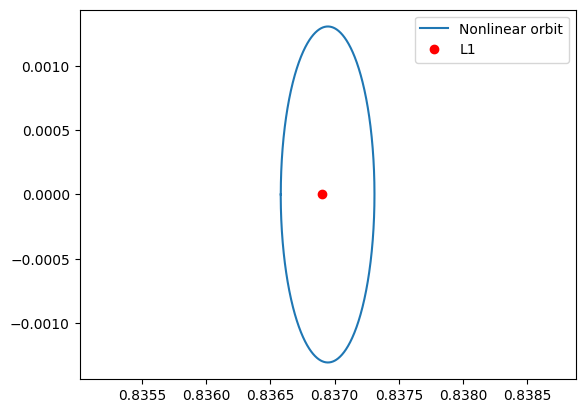

3.188279315257338


In [56]:
# Now integrate the equations of motion
Y_guess = Y_guess.flatten()
Y0 = [Y_guess[0], 0, 0, Y_guess[1]]
Y0 = np.concatenate((Y0, PHI0.flatten()))
T = Y_guess[2]

tau_span = np.linspace(0, 1, 1000)
sol_nl = solve_ivp(f, [0, 1], Y0, args = (T, mu), t_eval=tau_span, method='LSODA', rtol=3*eps, atol=eps)

# Plot the solution
plt.plot(sol_nl.y[0, :], sol_nl.y[1, :], label='Nonlinear orbit')

plt.plot(XL1[0], XL1[1], 'ro', label='L1')
# Dont stretch the plot
plt.axis('equal')
plt.legend()
plt.show()

# Compute the C value of the orbit
C_nl = Jacobi(Y0[0:2], Y0[2:4], mu)
print(C_nl)


In [57]:
### PAC (Pseudo Arclength Continuation) cell

# We have DX, DF and F_X of the last correct iteration
# Find tau_tan as null(DF) and Y0 as the last correct initial state
X_k_old = Y0[0:4]
delta_s = 1e-3

tan_tau = splin.null_space(DF) # Tau is now a row vector
print(f"tan_tau: {tan_tau}")


Y_guess_old = Y_guess.reshape(3,1)
Y_guess_new = Y_guess_old + delta_s*tan_tau
print(f"Y_guess_old: {Y_guess_old}")
print(f"Y_guess_new: {Y_guess_new}")




tan_tau: [[-0.11797227]
 [ 0.99299377]
 [ 0.00677602]]
Y_guess_old: [[0.83658071]
 [0.00304914]
 [2.69178148]]
Y_guess_new: [[0.83646273]
 [0.00404214]
 [2.69178826]]


In [58]:

# Solve again the TPBVP
G_X = np.ones((3,1))
DG = np.zeros((3,3))


while np.linalg.norm(G_X) > 1e-12:
    # Shoot
    DX, DF, F_X = shooting(Y_guess_new, mu)

    # G_X = [F_X(2x1), tan_tau'*(Y_guess_new - Y_guess_old)-delta_s(1x1)]
    G_X[0:2] = F_X
    G_X[2] = tan_tau.T@(Y_guess_new - Y_guess_old) - delta_s
    if (np.linalg.norm(G_X) > 1e-12):
        # DG = [DF; tau.T]
        DG[0:2, :] = DF
        DG[2,:] = tan_tau.T
        # Update guess
        Y_guess_new = Y_guess_new - np.linalg.inv(DG)@G_X
    else:
        # We verified that |G_X| < 1e-12, so continue
        # to exit the loop
        continue


# For good measure, print Y_guess
print(f"Y_guess: {Y_guess_new}")
print(f"Accuracy: {F_X}")

Y_guess: [[0.83646279]
 [0.00404251]
 [2.69173498]]
Accuracy: [[-2.60908871e-13]
 [-1.82623634e-13]]


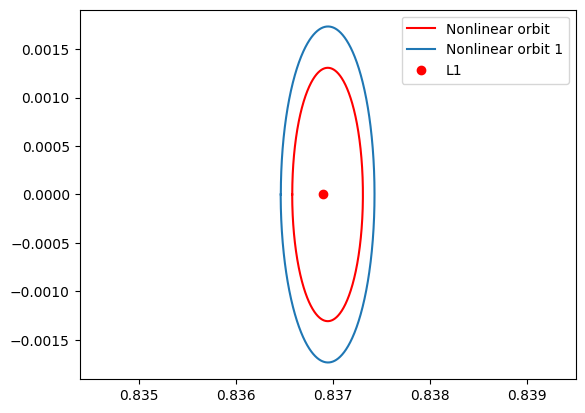

3.1882733924844455


In [60]:
# Now again, take the found initial state and plot it
Y_guess_new = Y_guess_new.flatten()
Y0_1 = [Y_guess_new[0], 0, 0, Y_guess_new[1]]
Y0_1 = np.concatenate((Y0_1, PHI0.flatten()))
T = Y_guess_new[2]

tau_span = np.linspace(0, 1, 1000)
sol_nl_1 = solve_ivp(f, [0, 1], Y0_1, args = (T, mu), t_eval=tau_span, method='LSODA', rtol=3*eps, atol=eps)

# Plot the solution
plt.plot(sol_nl.y[0, :], sol_nl.y[1, :],"r", label='Nonlinear orbit')
plt.plot(sol_nl_1.y[0, :], sol_nl_1.y[1, :], label='Nonlinear orbit 1')

plt.plot(XL1[0], XL1[1], 'ro', label='L1')
# Dont stretch the plot
plt.axis('equal')
plt.legend()
plt.show()

# Compute the C value of the orbit
C_nl = Jacobi(Y0_1[0:2], Y0_1[2:4], mu)
print(C_nl)


